In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Reshape, TimeDistributed, Flatten, RepeatVector
from keras.layers import LSTM
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

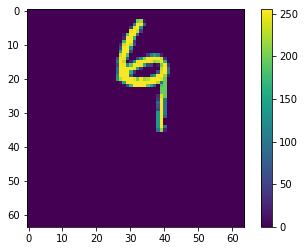

(9900, 10, 64, 64, 1)
(9900, 10, 64, 64, 1)


In [8]:
data = np.load("MNIST_test_seq.npy")
data = np.swapaxes(data, 0, 1)

data_test_input = data[100:10000, :10, :, :]
data_test_output = data[100:10000, 10:20, :, :]

data_actual_test_input = data[0:100, :10, :, :]
data_actual_test_output = data[0:100, 10:20, :, :]

plt.imshow(data_test_input[4][0])
plt.colorbar()
plt.show()

#Scaling values between -1 and 1
data_test_input = (data_test_input - 127.5) / 255.0
data_test_output = (data_test_output - 127.5) / 255.0
data_actual_test_input = (data_actual_test_input - 127.5) / 255.0
data_actual_test_output = (data_actual_test_output - 127.5) / 255.0

#Adding Channels of dimension 1 IMPORTANT if using CNNs
train_in = np.expand_dims(data_test_input, axis=4)
train_out = np.expand_dims(data_test_output, axis=4)
test_in = np.expand_dims(data_actual_test_input, axis=4)
test_out = np.expand_dims(data_actual_test_output, axis=4)

print(train_in.shape)
print(train_out.shape)

# output_frames.shape
# output_frames = np.squeeze(output_frames, axis=1)
# test_output_frames = np.squeeze(test_output_frames, axis=1)
# plt.plot(test_output_frames[0])
# plt.show()

# output_frames.shape
# plt.imshow(np.squeeze(test_output_frames[1], axis=2))
# plt.show()

In [9]:
#Define filters
filters = 10

model3 = Sequential()
model3.add(ConvLSTM2D(filters=filters, kernel_size=(3, 3),
                   input_shape=(10, 64, 64, 1),
                   padding='same', return_sequences=True))
model3.add(BatchNormalization())

model3.add(ConvLSTM2D(filters=filters, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model3.add(BatchNormalization())

model3.add(ConvLSTM2D(filters=filters, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model3.add(BatchNormalization())

model3.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   padding='same'))

out_size = model3.layers[-1].output_shape
num_repeat = 10

model3.add(Flatten())
model3.add(RepeatVector(num_repeat))
model3.add(Reshape(tuple([num_repeat]) + out_size[1:]))

model3.add(ConvLSTM2D(filters=filters, kernel_size=(3, 3),
                   input_shape=(10, 64, 64, 1),
                   padding='same', return_sequences=True))

model3.add(ConvLSTM2D(filters=filters, kernel_size=(3, 3),
                   input_shape=(10, 64, 64, 1),
                   padding='same', return_sequences=True))

model3.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   input_shape=(10, 64, 64, 1),
                   padding='same', return_sequences=True))


#Have model return one image with one channel/filter
#Output shape = (batch_size, 1, 64, 64, 1)
# model3.add(BatchNormalization())

# model3.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
#                activation='sigmoid',
#                padding='same', data_format='channels_last'))
model3.compile(loss='mse', optimizer='adam')
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_8 (ConvLSTM2D)  (None, 10, 64, 64, 10)    4000      
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 64, 64, 10)    40        
_________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)  (None, 10, 64, 64, 10)    7240      
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 64, 64, 10)    40        
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, 10, 64, 64, 10)    7240      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 64, 64, 10)    40        
_________________________________________________________________
conv_lst_m2d_11 (ConvLSTM2D) (None, 64, 64, 1)        

In [12]:
model3 = keras.models.load_model('model3_epoch100.h5')

In [6]:
print(train_out.shape)

(9900, 10, 64, 64, 1)


In [ ]:
for epoch in range(1,251):
    print("Epoch:",epoch)
    model3.fit(train_in, train_out, batch_size=10, epochs = 1)
    
    inputs = train_in[epoch*10: (epoch+1)*10]
    ground_truth = train_out[epoch*10: (epoch+1)*10]
    predictions = model3.predict(inputs)
#     predictions = predictions.reshape(10, 64, 64)
#     ground_truth = ground_truth.reshape(10, 64, 64)
#     plt.figure(figsize=(20, 20))
#     for i in range(predictions.shape[0]):
#         plt.subplot(10, 10, i+1)
#         plt.imshow(predictions[i], interpolation='nearest')
#         plt.subplot(10, 10, 10+i+1)
#         plt.imshow(ground_truth[i], interpolation='nearest')
#         plt.axis('off')
#     plt.show()
#     plt.tight_layout()
    if epoch % 10 == 0:
        model3.save('multiframeconvlstm_epoch'+str(epoch)+'.h5')
    print('-----------------------------------')

Epoch: 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1
 220/9900 [..............................] - ETA: 1:10:32 - loss: 0.1283